# Hydrodynamics of 3 Particles to check Hydrodynamics in System

In this script it is going to be compare the dynamics of 3 particles of our system with the results presented in the thesis of C. Lutz. This comparison is taken to see if there is hydrodynamic interaction between particles in our system.

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as spo
from scipy.stats import norm

import matplotlib.mlab as mlab

import pims
import pint

from tqdm import tqdm_notebook as prog_bar

import support as sp

idx = pd.IndexSlice
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
# From https://stackoverflow.com/questions/2537868/sans-serif-math-with-latex-in-matplotlib
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 

mpl.rcParams.update({'figure.dpi': 200})

mpl.rcParams.update({'font.size': 10})

ureg = pint.UnitRegistry()
column = 18*ureg.cm

In [3]:
directory = r"Z:\BASEP\Datasets\Test_u0_cte"
index = pd.read_csv(directory+'\\'+"index.dat", sep="\t", index_col = [0,1])
index = index.sort_index()
index.head()

Filename  omega  radius  wavelength
sigma N_particles                                            
0.98  27.0         Test20_20190617   0.72   17.43        4.18
      26.0         Test21_20190617   0.72   17.43        4.18
      23.0         Test22_20190617   0.72   17.43        4.18
      20.0         Test23_20190617   0.72   17.43        4.18
      17.0         Test24_20190617   0.72   17.43        4.18

In [4]:
def sort_particles_in_circle_multiframe(trj):
    
    all_id = pd.DataFrame()
    
    for f in trj.index.get_level_values("time").unique().to_list():
        
        new_id = trj.loc[idx[f,:],:].sort_values("theta").filter(["theta"])
        new_id["id"] = range(0,len(new_id))
        new_id = new_id.sort_index()
        
        all_id = all_id.append(new_id, ignore_index=True)
        #trj.loc[idx[f,:], :] = trj.loc[idx[f,:], :].index.set_levels(new_id.id, level="particle")

    trj = trj.reset_index()
    trj.particle = all_id.id #new_id.id.values
    trj = trj.set_index(["frame", "particle"]).sort_index()
    
    return trj.sort_index()

In [5]:
def sort_particles_in_circle(trj):
    
    # The new id will replace the old particle id. They are the same, except the new one is sorted by increasing angle. 
    
    new_id = trj.loc[idx[0,:],:].sort_values("theta").filter(["theta"])
    new_id["id"] = range(0,len(new_id))
    new_id = new_id.sort_index()
    
    trj.index = trj.index.set_levels(new_id.id.values,level = 1)
    
    return trj.sort_index()

$\sigma$ = 0.62 and 0.75 won't be considered because there is no 3 particle data.

In [6]:
df = pd.DataFrame()

sigma = [0.98, 0.9, 0.8, 0.85]
p = 3

for s in prog_bar(sigma):

    trj_path = directory+r'\Trajectories\Trajectory_'+index.loc[idx[s,p], "Filename"]

    Nparticles = p
    wavlen = index.loc[idx[s,p], "wavelength"]
    radius = index.loc[idx[s,p], "radius"]
    omega = index.loc[idx[s,p], "omega"]
    particleDens = Nparticles*4/(2*np.pi*radius) #4 is the particle diameter

    trj = sp.trjLoading(trj_path+".dat")
    trj = sort_particles_in_circle(trj)
    trj = sp.movementAnalyser(trj, omega)
    trj["particle_density"] = particleDens
    trj["sigma"] = s
    trj = trj.reset_index()

    df = df.append(trj, ignore_index=True)

del df["frame"]
df = df.set_index(["sigma","particle","time"], drop=True)
df["time"] = df.index.get_level_values("time")
df = df.sort_index()
df.head()

x          y          r     theta  theta_unwrap  \
sigma particle time                                                             
0.8   0        0.000  16.260955 -13.866968  21.370809 -0.706104     -0.706104   
               0.016  16.518495 -13.750134  21.492483 -0.694192     -0.694192   
               0.033  16.380489 -13.573131  21.273230 -0.691948     -0.691948   
               0.050  16.599404 -13.523480  21.410855 -0.683638     -0.683638   
               0.066  16.606223 -13.505223  21.404618 -0.682776     -0.682776   

                      theta_dot  theta_prime  theta_prime_unwrap  \
sigma particle time                                                
0.8   0        0.000        NaN     5.577081            5.577081   
               0.016   0.744501     5.579553            5.579553   
               0.033   0.132033     5.571768            5.571768   
               0.050   0.488776     5.570047            5.570047   
               0.066   0.053909     5.561470            5.561470   

                      theta_dot_prime  particle_density   time  
sigma particle time                                             
0.8   0        0.000              NaN          0.089455  0.000  
               0.016         0.154501          0.089455  0.016  
               0.033        -0.457967          0.089455  0.033  
               0.050        -0.101224          0.089455  0.050  
               0.066        -0.536091          0.089455  0.066

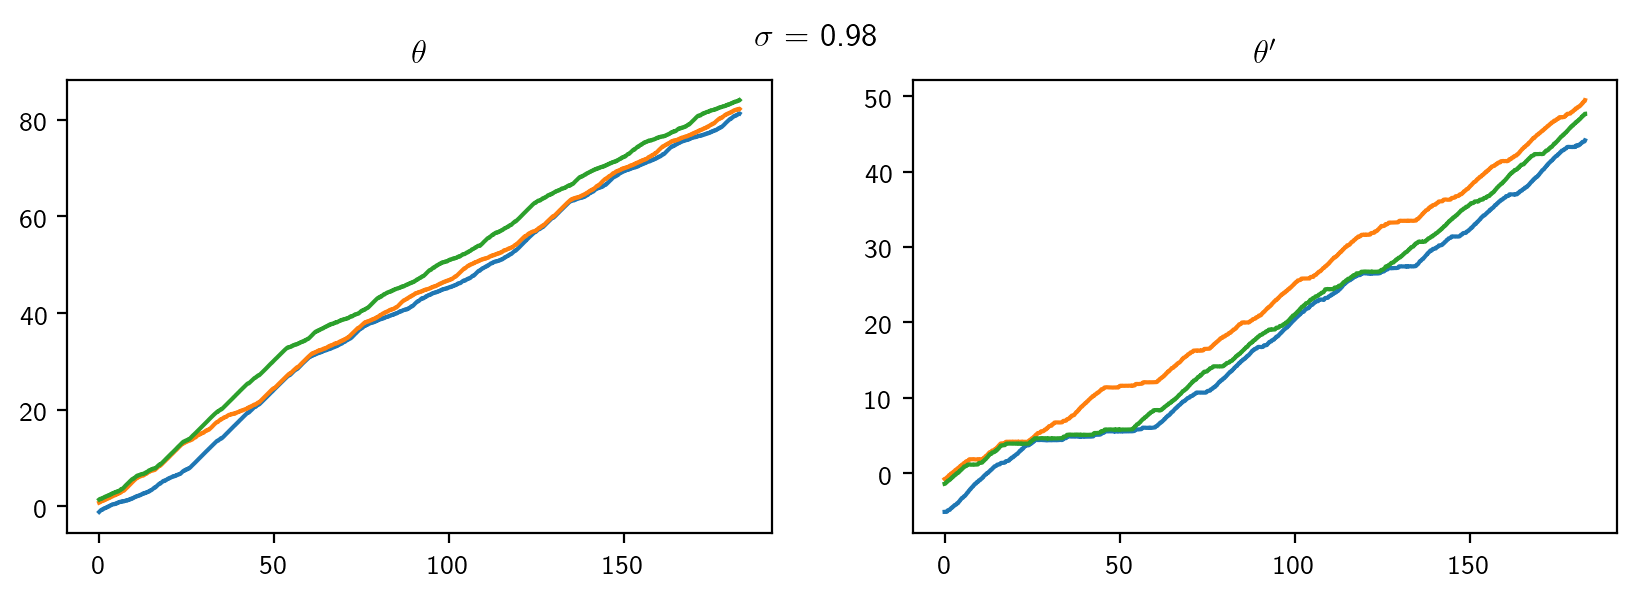

In [7]:
fig, ay = plt.subplots(1,2,figsize = (10,3))

for p, trj_sub in df.loc[idx[0.98,:,:],:].groupby("particle"):
    ay[0].plot(trj_sub.time, trj_sub.theta_unwrap)
    ay[1].plot(trj_sub.time, -trj_sub.theta_prime_unwrap)
    
fig.suptitle("$\sigma$ = 0.98")
ay[0].set_title(r"$\theta$")
ay[1].set_title(r"$\theta '$");

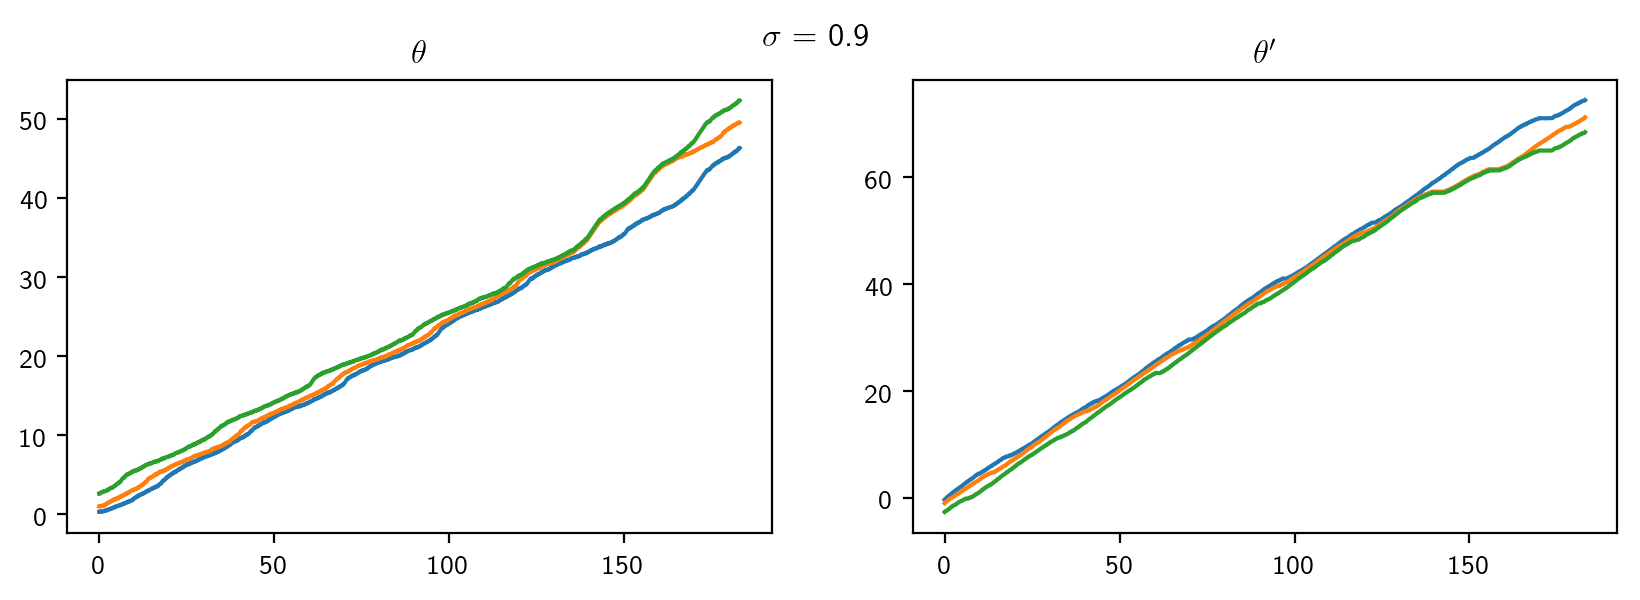

In [8]:
fig, ay = plt.subplots(1,2,figsize = (10,3))

for p, trj_sub in df.loc[idx[0.9,:,:],:].groupby("particle"):
    ay[0].plot(trj_sub.time, trj_sub.theta_unwrap)
    ay[1].plot(trj_sub.time, -trj_sub.theta_prime_unwrap)
    
fig.suptitle("$\sigma$ = 0.9")
ay[0].set_title(r"$\theta$")
ay[1].set_title(r"$\theta '$");

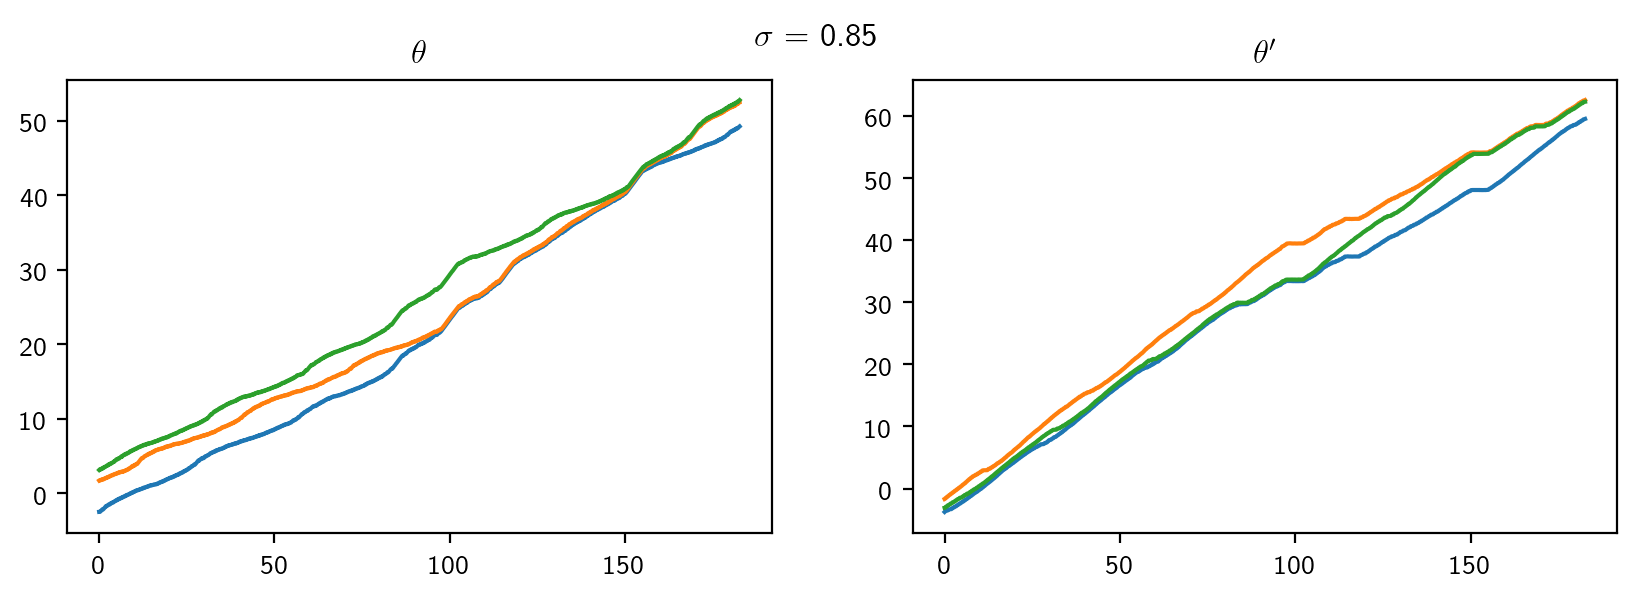

In [9]:
fig, ay = plt.subplots(1,2,figsize = (10,3))

for p, trj_sub in df.loc[idx[0.85,:,:],:].groupby("particle"):
    ay[0].plot(trj_sub.time, trj_sub.theta_unwrap)
    ay[1].plot(trj_sub.time, -trj_sub.theta_prime_unwrap)

fig.suptitle("$\sigma$ = 0.85")
ay[0].set_title(r"$\theta$")
ay[1].set_title(r"$\theta '$");

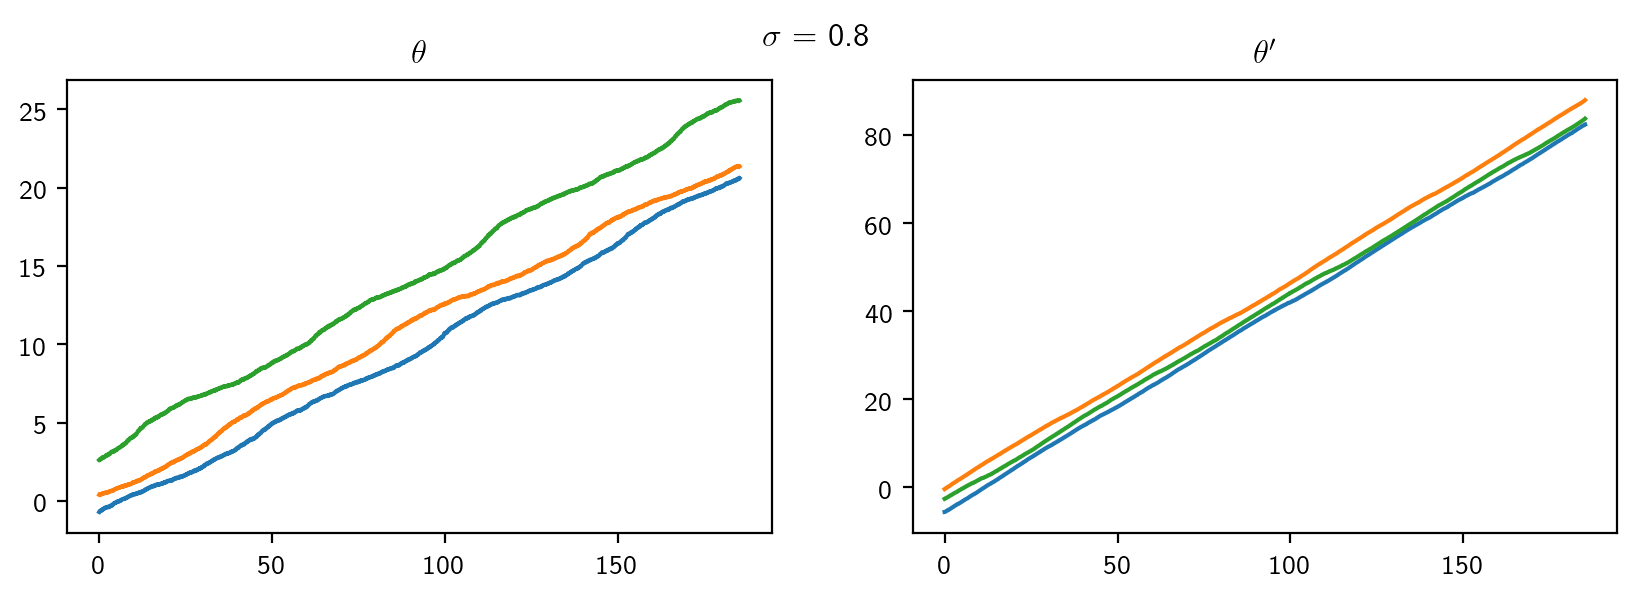

In [10]:
fig, ay = plt.subplots(1,2,figsize = (10,3))

for p, trj_sub in df.loc[idx[0.8,:,:],:].groupby("particle"):
    ay[0].plot(trj_sub.time, trj_sub.theta_unwrap)
    ay[1].plot(trj_sub.time, -trj_sub.theta_prime_unwrap)

fig.suptitle("$\sigma$ = 0.8")
ay[0].set_title(r"$\theta$")
ay[1].set_title(r"$\theta '$");

From the graphics above, comparing to the graph reported by the thesis of C. Lutz, the situation with the most similar behaviour is $\sigma = 0.98$. Maybe is possible the hydrodynamic effects get more importance depending on the potential landscape wavelength, having the biggest effect for $\sigma = 0.98$ and having very low presence for the other situations. 

Can we quantify this? :S

Next it is plot the velocity of the particles. The aim is try to quantify this behaviour, will the particles move faster toghether?

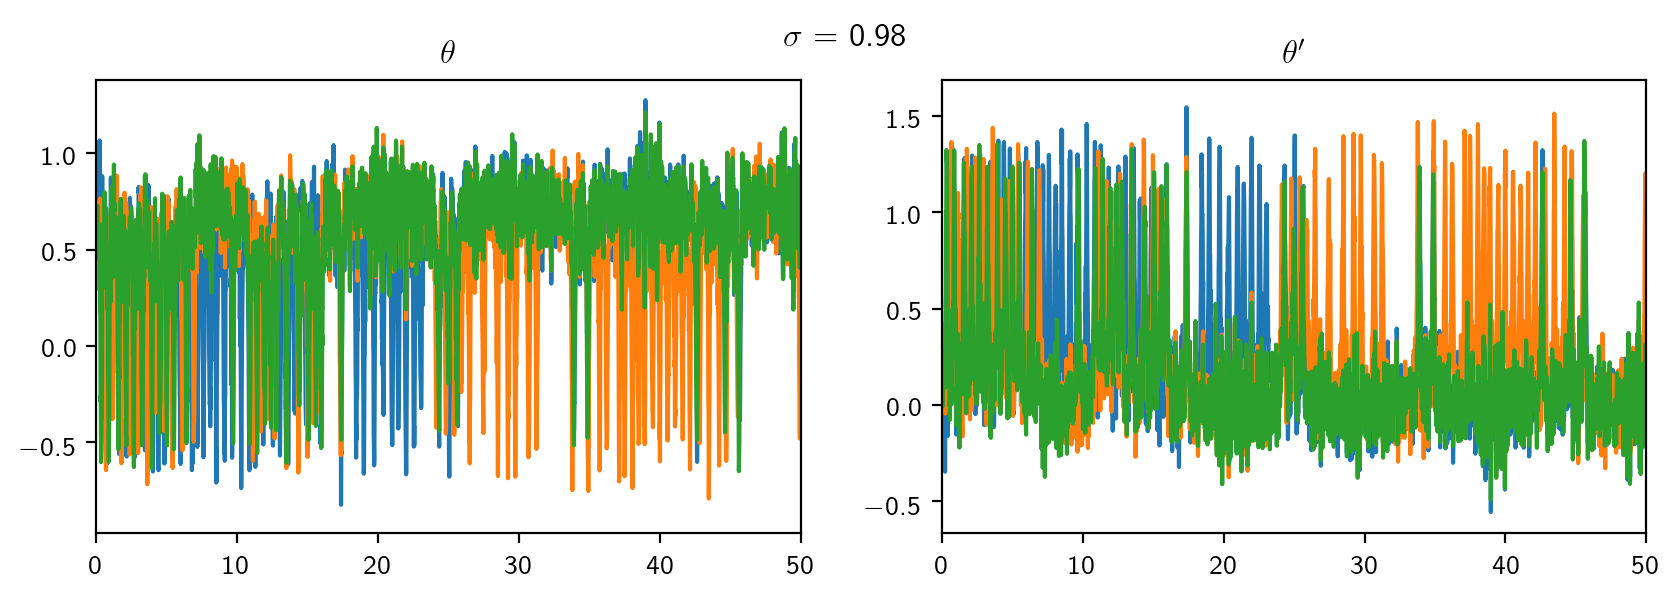

In [11]:
fig, ay = plt.subplots(1,2,figsize = (10,3))

lowcut = 0.2

for p, trj_sub in df.loc[idx[0.98,:],:].groupby("particle"):
    ay[0].plot(trj_sub.time, trj_sub.theta_dot.rolling(3).mean())
    ay[1].plot(trj_sub.time, -trj_sub.theta_dot_prime.rolling(3).mean())
    
fig.suptitle("$\sigma$ = 0.98")
ay[0].set_title(r"$\theta$")
ay[1].set_title(r"$\theta '$");
ay[0].set_xlim([0,50]);
ay[1].set_xlim([0,50]);

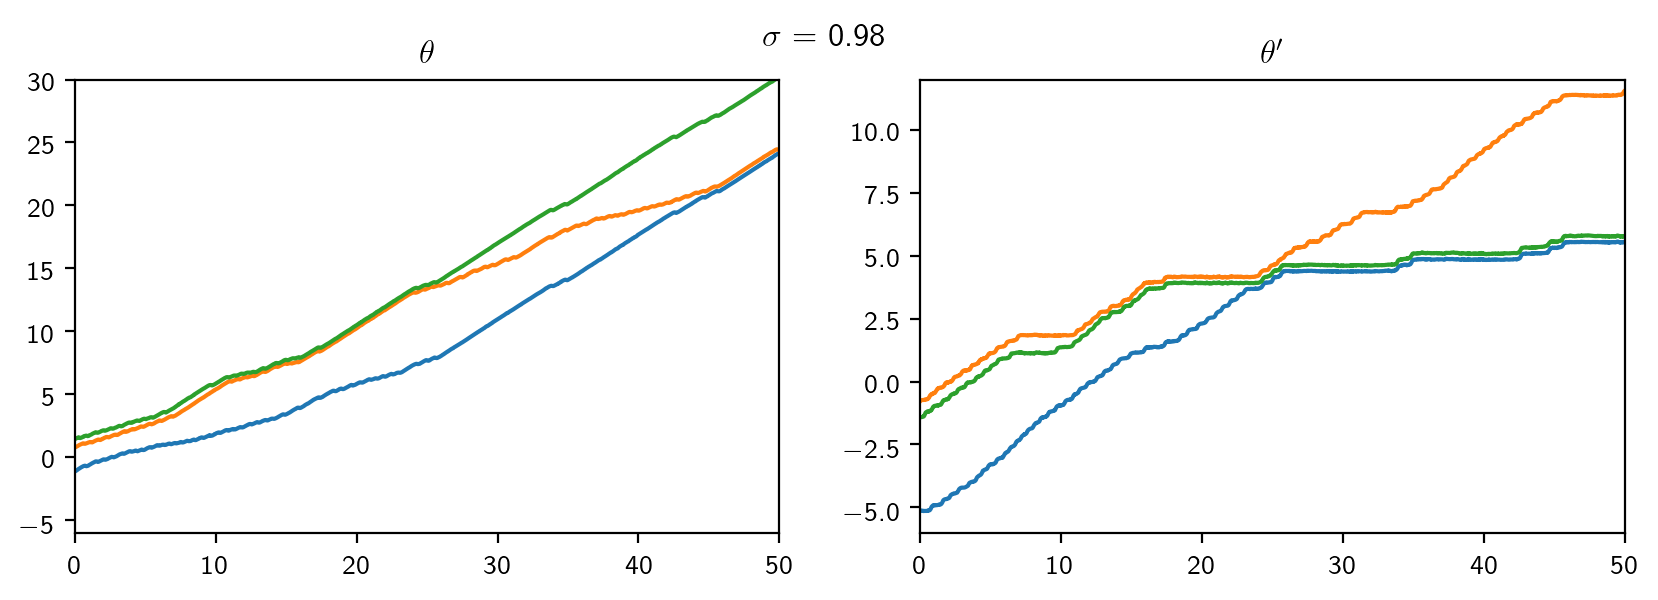

In [12]:
fig, ay = plt.subplots(1,2,figsize = (10,3))

for p, trj_sub in df.loc[idx[0.98,:],:].groupby("particle"):
    ay[0].plot(trj_sub.time, trj_sub.theta_unwrap)
    ay[1].plot(trj_sub.time, -trj_sub.theta_prime_unwrap)
    
fig.suptitle("$\sigma$ = 0.98")
ay[0].set_title(r"$\theta$")
ay[1].set_title(r"$\theta '$");
ay[0].set_xlim([0,50]);
ay[1].set_xlim([0,50]);
ay[0].set_ylim([-6,30]);
ay[1].set_ylim([-6,12]);

It seems this rough method to see if the two particles are faster than one is not effective. 

Below it is going to be done more in detail.

In [13]:
def angle_diff(p,df,field):
    this = df.loc[idx[:,p,:],[field]].reset_index(level = 1, drop=True)
    that = df.loc[idx[:,np.mod(p+1,3),:],[field]].reset_index(level = 1, drop=True)
    
    delta = this-that
    delta["index1"] = p
    delta["index2"] = np.mod(p+1,3)
    delta[field] = np.min(np.array([abs(delta.values),2*np.pi-abs(delta.values)]),axis=0)
    
    return delta

In [14]:
delta_theta = pd.concat(
    [angle_diff(p,df,"theta_prime") for p, series in df.loc[idx[:,:,:],:].groupby("particle")],
    keys = df.loc[idx[:,:,:],:].groupby("particle").count().index, names=["interval"])

delta_theta.head()

theta_prime  index1  index2
interval sigma time                              
0        0.8   0.000     1.094804       0       1
               0.016     1.081703       0       1
               0.033     1.082303       0       1
               0.050     1.070746       0       1
               0.066     1.070410       0       1

In [15]:
diff_values = delta_theta.loc[idx[0,0.98,:],"theta_prime"].values 
min_val = []

for i in np.linspace(0,1300,1301,dtype=int):
    min_val.append(np.min(diff_values))
    diff_values = np.setdiff1d(diff_values, min_val[i])
    
print(min_val[1])
print(min_val[-1])
print("Mean = ", np.mean(min_val))
print("STD = ",np.std(min_val))

0.2279112143323161
0.2925855002394684
Mean =  0.24598245855046472
STD =  0.013234631246832726


It is going to be stablished the rule that two particles will be considered to be toghether if the difference in angle btween them is less than 0.25 rad. With this, it is going to be determined which particles are advancing toghether, then I am going to make an histrogram of particles' velocities to compare the velocity regime when they are alone or in cluster.

In [16]:
delta_theta["cluster"] = 0
delta_theta["cluster"][delta_theta.theta_prime.round(2)<=0.25] = 1

C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
df["cluster"] = 0
for i, t_sub in delta_theta.groupby("interval"):
    for s, delta_sub in t_sub.groupby("sigma"):
        
        p1 = delta_sub.index1.unique()[0]
        p2 = delta_sub.index2.unique()[0]

        df.loc[idx[s,p1,:],"cluster"] += delta_sub.cluster.reset_index(level=[0,1], drop =True)
        df.loc[idx[s,p2,:],"cluster"] += delta_sub.cluster.reset_index(level=[0,1], drop =True)

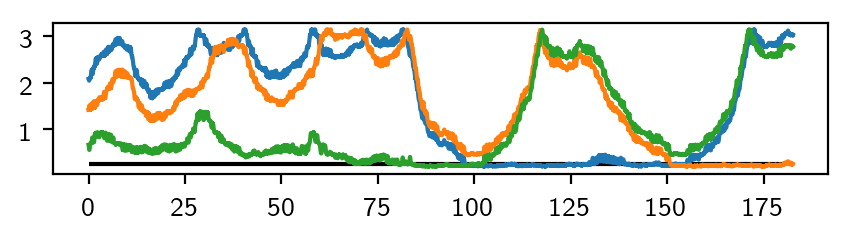

In [18]:
plt.figure(figsize=(5,1))
delta_theta["time"] = delta_theta.index.get_level_values("time")
plt.plot(delta_theta.loc[idx[0,0.85,:],"time"],delta_theta.loc[idx[0,0.85,:],"theta_prime"])
plt.plot(delta_theta.loc[idx[1,0.85,:],"time"],delta_theta.loc[idx[1,0.85,:],"theta_prime"])
plt.plot(delta_theta.loc[idx[2,0.85,:],"time"],delta_theta.loc[idx[2,0.85,:],"theta_prime"])
plt.hlines(0.25, 0,180)

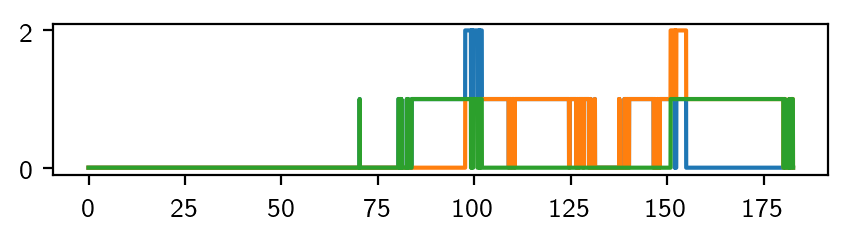

In [19]:
plt.figure(figsize=(5,1))
plt.plot(df.loc[idx[0.85,0,:],"time"], df.loc[idx[0.85,0,:],"cluster"])
plt.plot(df.loc[idx[0.85,1,:],"time"], df.loc[idx[0.85,1,:],"cluster"])
plt.plot(df.loc[idx[0.85,2,:],"time"], df.loc[idx[0.85,2,:],"cluster"])

C:\Users\Eric\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Eric\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


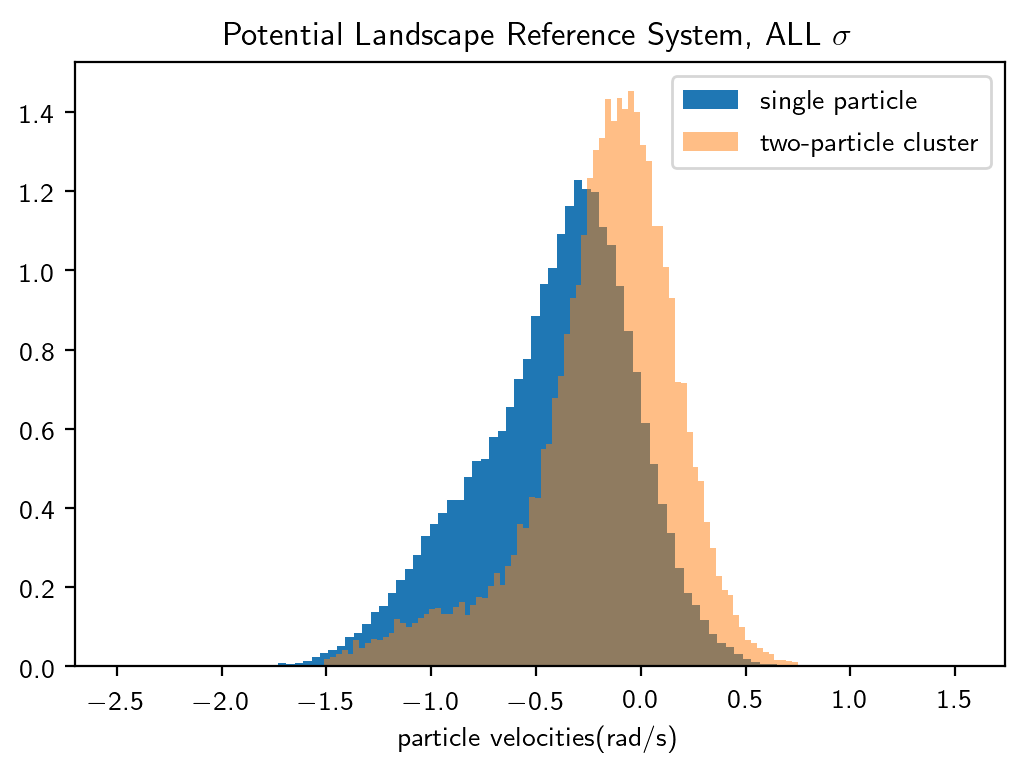

In [20]:
plt.hist(df.theta_dot_prime[df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.theta_dot_prime[df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities(rad/s)");
plt.title("Potential Landscape Reference System, ALL $\sigma$")
plt.legend();

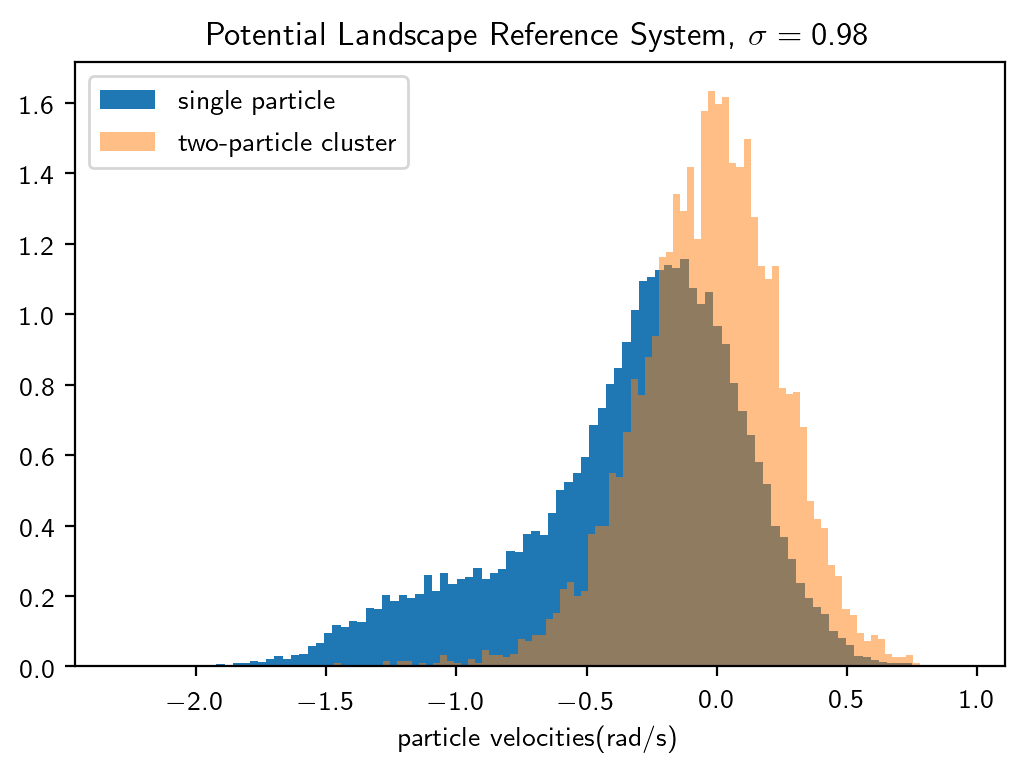

In [21]:
plt.hist(df.loc[idx[0.98,:,:],"theta_dot_prime"][df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.loc[idx[0.98,:,:],"theta_dot_prime"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities(rad/s)");
plt.title("Potential Landscape  Reference System, $\sigma = 0.98$")
plt.legend();

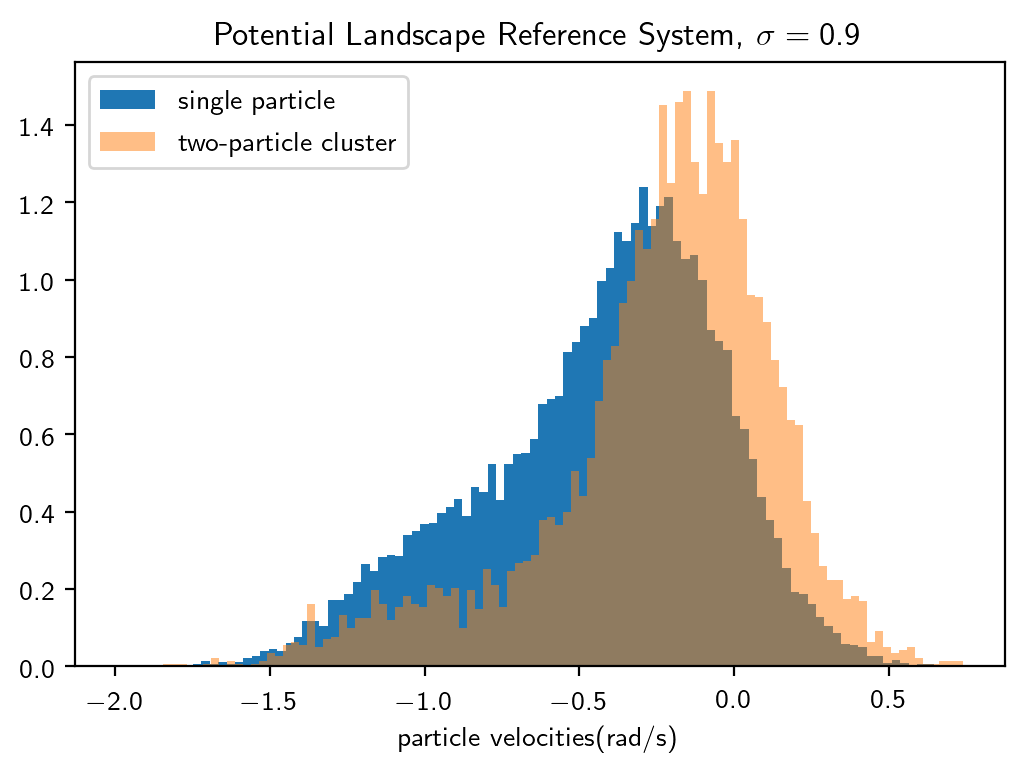

In [22]:
plt.hist(df.loc[idx[0.9,:,:],"theta_dot_prime"][df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.loc[idx[0.9,:,:],"theta_dot_prime"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities(rad/s)");
plt.title("Potential Landscape Reference System, $\sigma = 0.9$")
plt.legend();

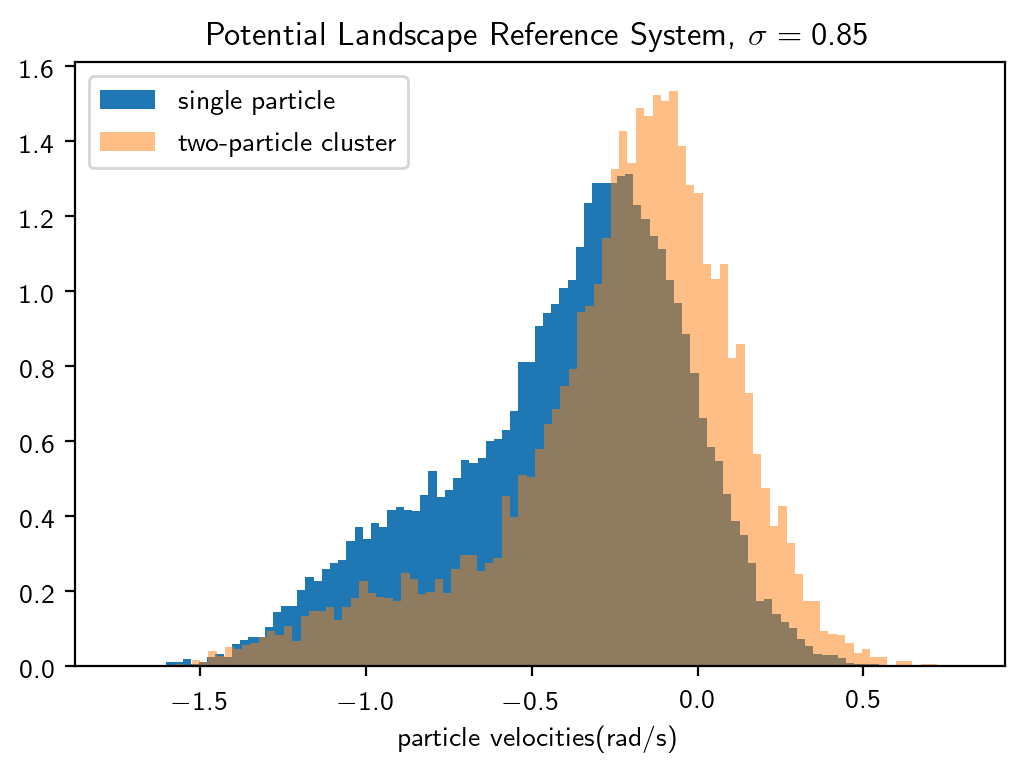

In [23]:
plt.hist(df.loc[idx[0.85,:,:],"theta_dot_prime"][df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.loc[idx[0.85,:,:],"theta_dot_prime"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities(rad/s)");
plt.title("Potential Landscape Reference System, $\sigma = 0.85$")
plt.legend();

# Change units to $\mu$/s for both reference systems

In [24]:
#Change velocity units to um/s
df.theta_dot = df.theta_dot*df.r
df.theta_dot_prime = df.theta_dot_prime*df.r

df.head()

x          y          r     theta  theta_unwrap  \
sigma particle time                                                             
0.8   0        0.000  16.260955 -13.866968  21.370809 -0.706104     -0.706104   
               0.016  16.518495 -13.750134  21.492483 -0.694192     -0.694192   
               0.033  16.380489 -13.573131  21.273230 -0.691948     -0.691948   
               0.050  16.599404 -13.523480  21.410855 -0.683638     -0.683638   
               0.066  16.606223 -13.505223  21.404618 -0.682776     -0.682776   

                      theta_dot  theta_prime  theta_prime_unwrap  \
sigma particle time                                                
0.8   0        0.000        NaN     5.577081            5.577081   
               0.016  16.001183     5.579553            5.579553   
               0.033   2.808768     5.571768            5.571768   
               0.050  10.465111     5.570047            5.570047   
               0.066   1.153901     5.561470            5.561470   

                      theta_dot_prime  particle_density   time  cluster  
sigma particle time                                                      
0.8   0        0.000              NaN          0.089455  0.000        0  
               0.016         3.320618          0.089455  0.016        0  
               0.033        -9.742437          0.089455  0.033        0  
               0.050        -2.167294          0.089455  0.050        0  
               0.066       -11.474824          0.089455  0.066        0

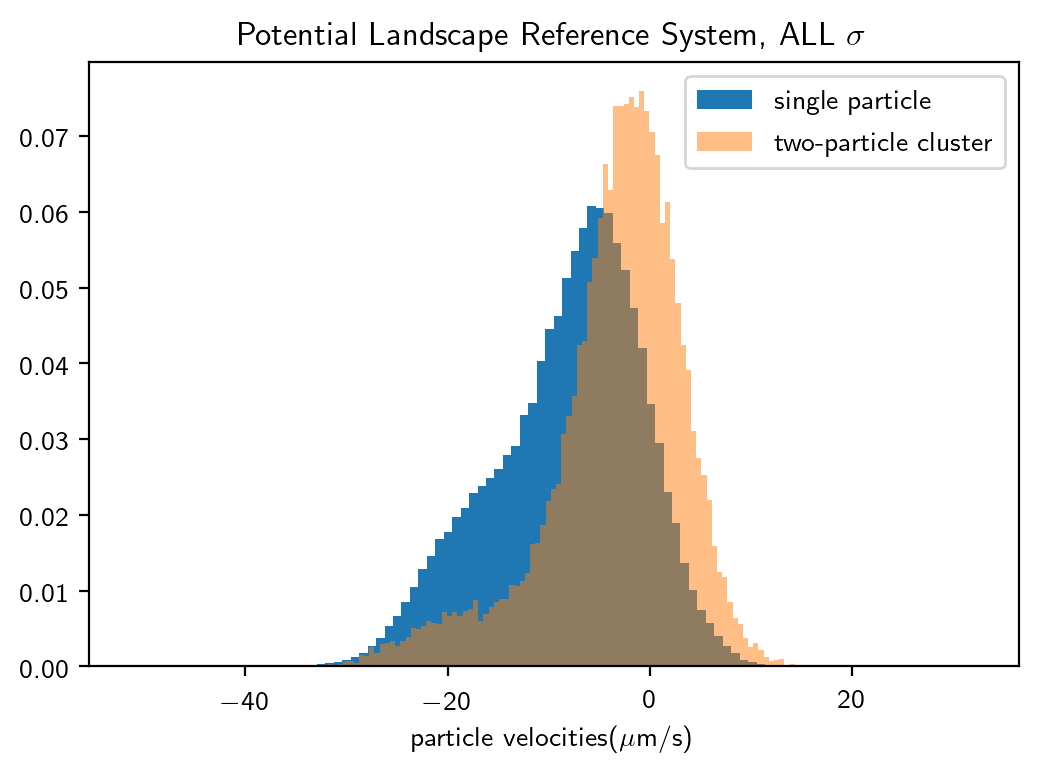

In [25]:
plt.hist(df.theta_dot_prime[df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.theta_dot_prime[df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities($\mu$m/s)");
plt.title("Potential Landscape Reference System, ALL $\sigma$")
plt.legend();

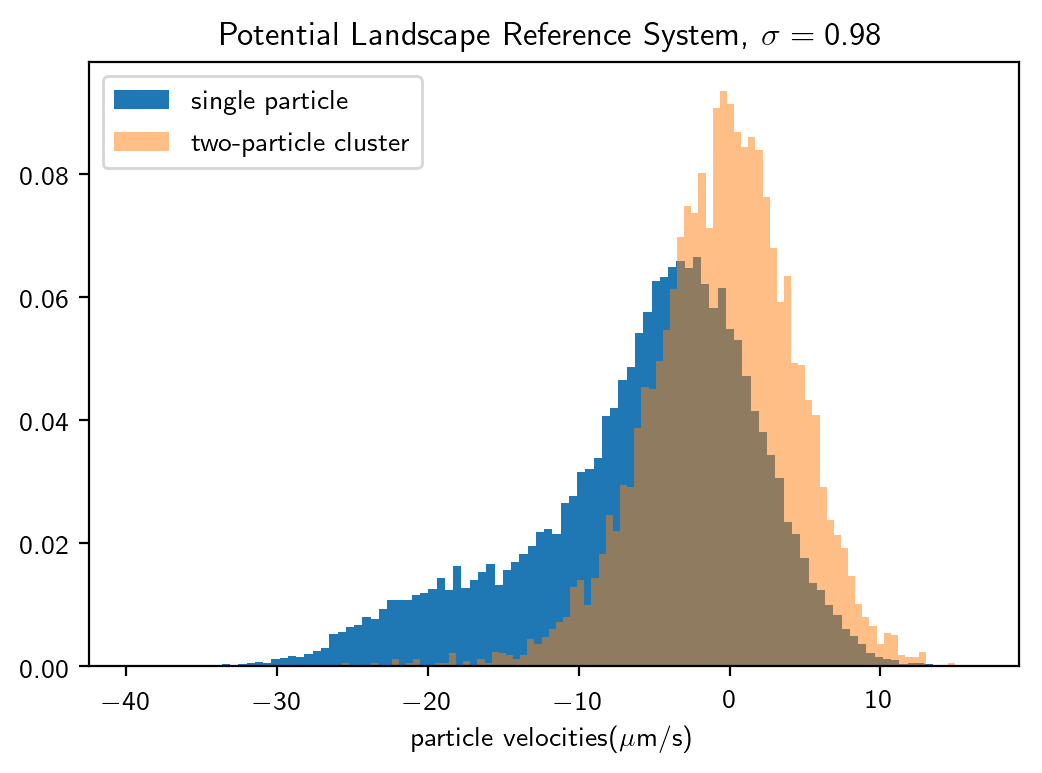

In [26]:
plt.hist(df.loc[idx[0.98,:,:],"theta_dot_prime"][df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.loc[idx[0.98,:,:],"theta_dot_prime"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities($\mu$m/s)");
plt.title("Potential Landscape  Reference System, $\sigma = 0.98$")
plt.legend();

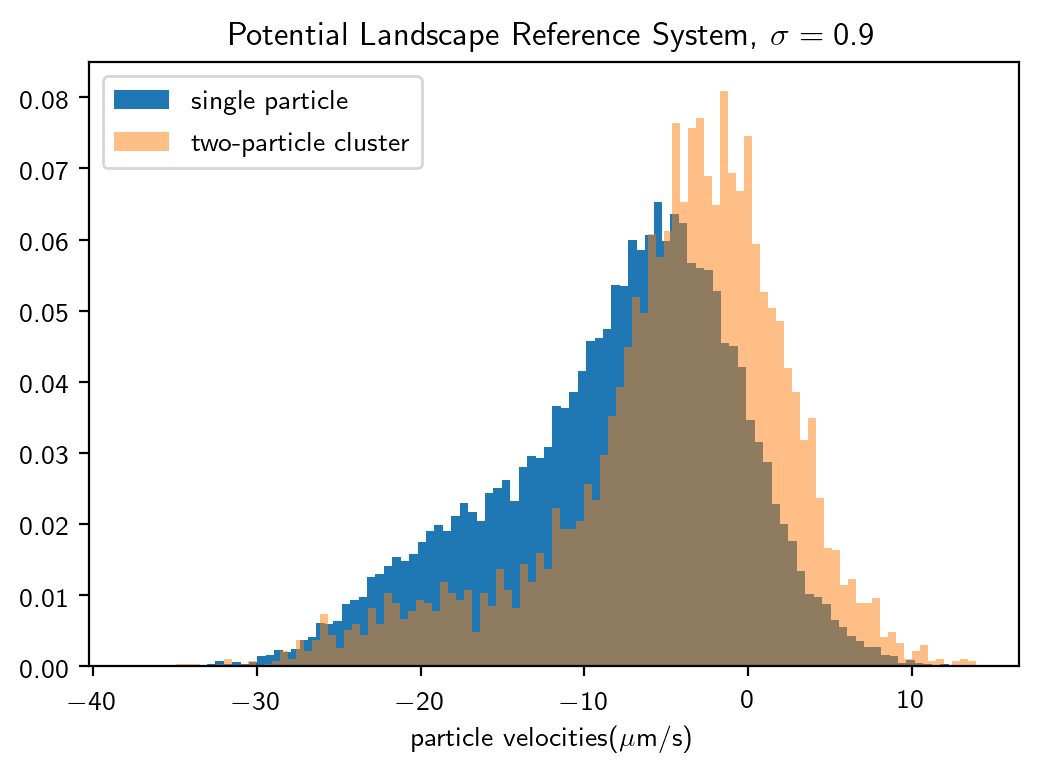

In [27]:
plt.hist(df.loc[idx[0.9,:,:],"theta_dot_prime"][df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.loc[idx[0.9,:,:],"theta_dot_prime"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel("particle velocities($\mu$m/s)");
plt.title("Potential Landscape Reference System, $\sigma = 0.9$")
plt.legend();

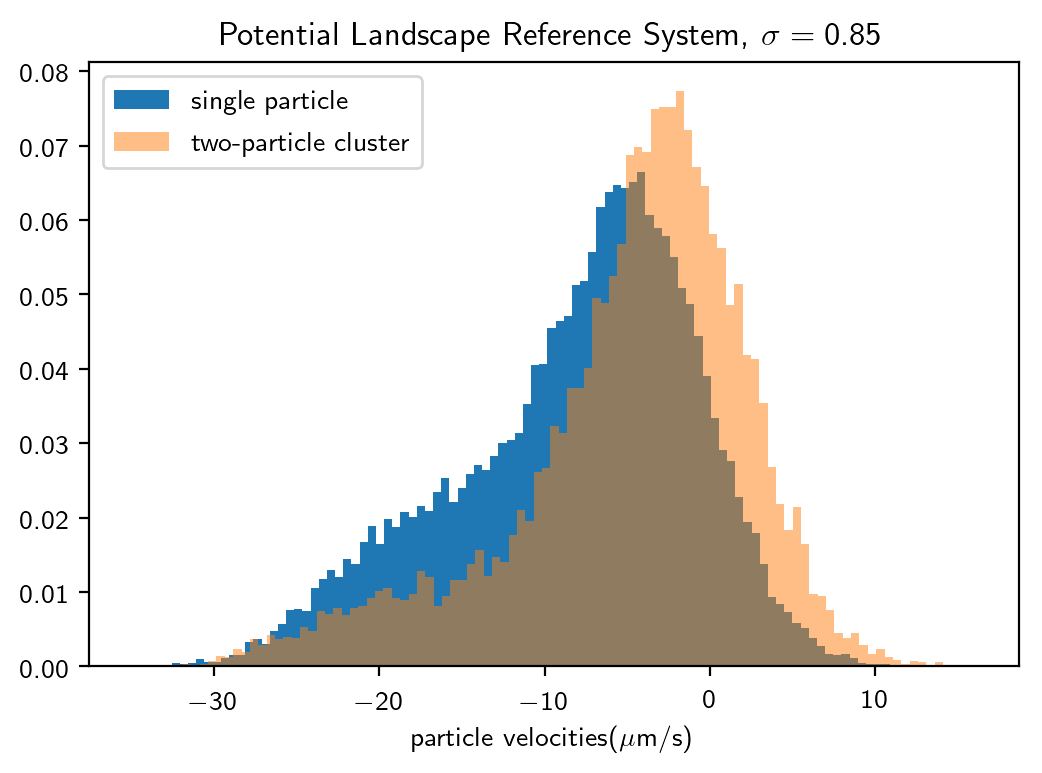

In [28]:
plt.hist(df.loc[idx[0.85,:,:],"theta_dot_prime"][df.cluster==0], 100, density = 1, label="single particle");
plt.hist(df.loc[idx[0.85,:,:],"theta_dot_prime"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);
plt.xlabel(r"particle velocities($\mu$m/s)");
plt.title("Potential Landscape Reference System, $\sigma = 0.85$")
plt.legend();

In [29]:
mean_velocities = pd.DataFrame()

for s, df_sub in df.groupby("sigma"):
    mean_velocities = mean_velocities.append({"sigma": s, "single_vel": abs(df_sub.theta_dot_prime[df_sub.cluster==0].mean()),
                                             "cluster_vel": abs(df_sub.theta_dot_prime[df_sub.cluster>0].mean())},
                                             ignore_index=True)
    
#The mean values of the velocities are saved in absolute value to don't take into account the particles move
#in the opposite sense of the traps
mean_velocities = mean_velocities.set_index("sigma")
mean_velocities.head()
#units in um/s

,cluster_vel,single_vel
sigma,,
0.80,NaN,10.083129
0.85,4.842917,8.161274
0.90,4.575503,8.138625
0.98,0.563564,5.839245


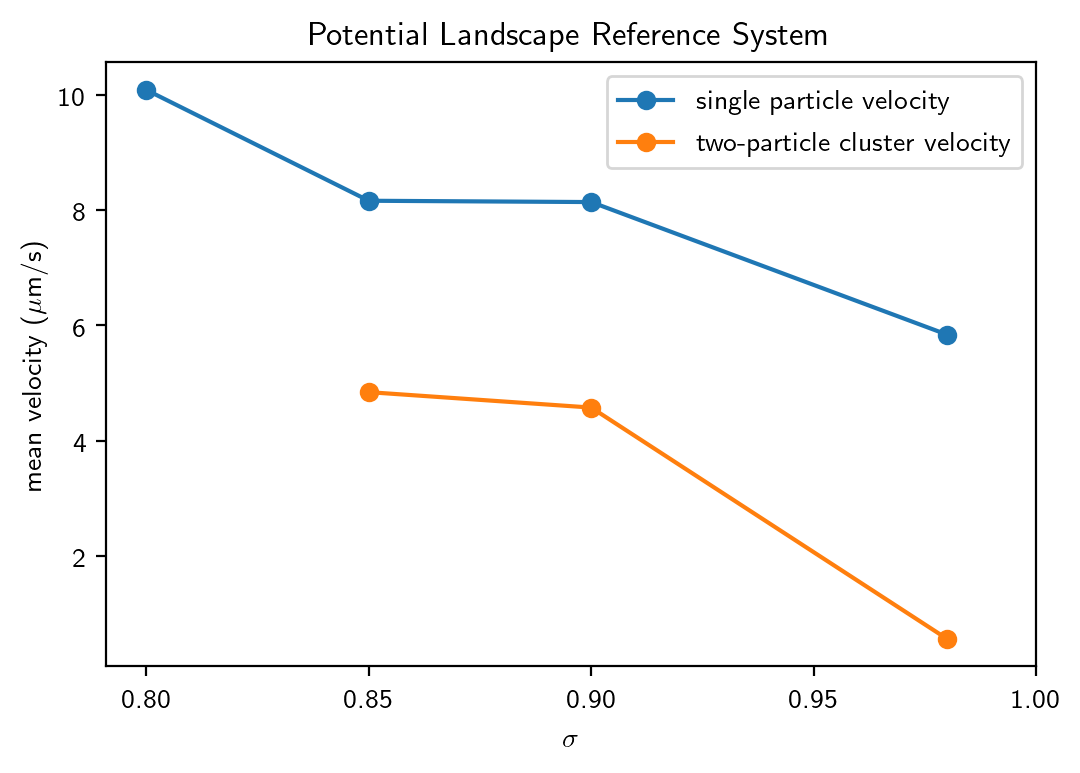

In [30]:
plt.plot(mean_velocities.single_vel, 'o-', label = "single particle velocity");
plt.plot(mean_velocities.cluster_vel, 'o-', label = "two-particle cluster velocity")
plt.ylabel("mean velocity ($\mu$m/s)")
plt.xlabel(r"$\sigma$")
# plt.ylim([-0.5,0])
# plt.xlim([0.79,1])
plt.xticks(np.linspace(0.8,1,5))
plt.title("Potential Landscape Reference System")
plt.legend();

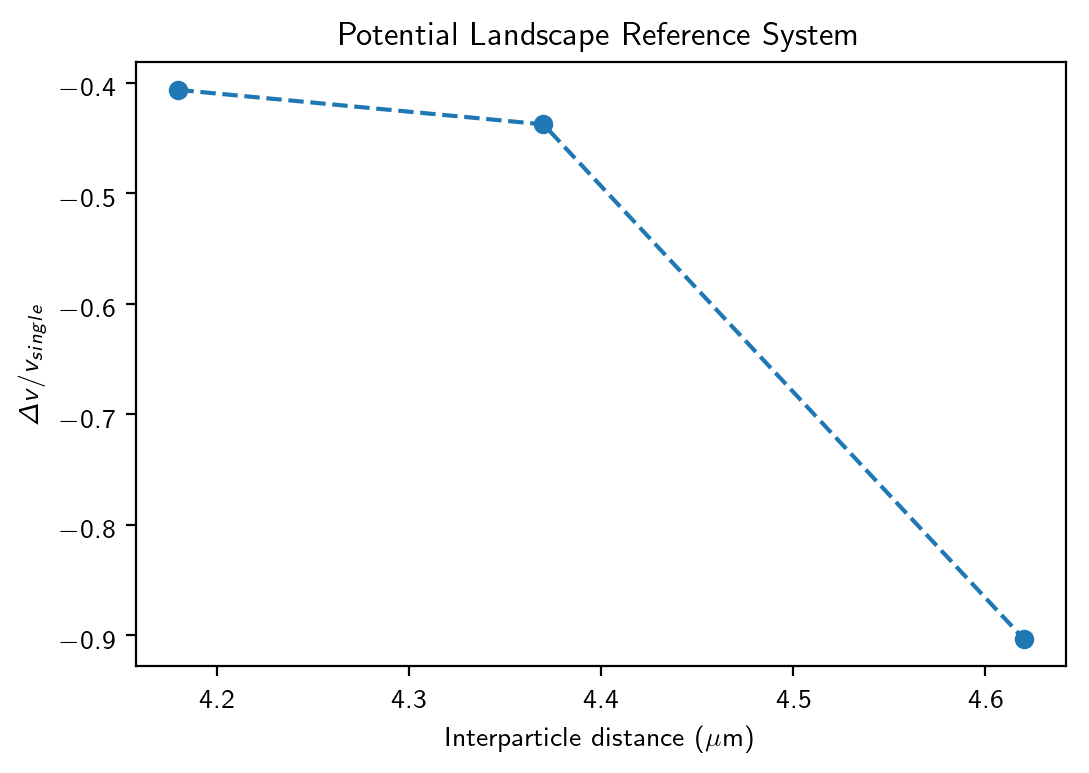

In [31]:
s_vel_pot = mean_velocities.single_vel.values[1:]
delta_v_pot = mean_velocities.cluster_vel.values[1:]-s_vel_pot
plt.plot(index.loc[idx[[0.85,0.9,0.98],3],"wavelength"].values, delta_v_pot/s_vel_pot, 'o--')
plt.ylabel(r"$\Delta v  / v_{single}$")
plt.xlabel(r"Interparticle distance ($\mu$m)");
# plt.ylim([-0.5,0])
#plt.xlim([0.84,1])
#plt.xticks(np.linspace(0.85,1,4))
plt.title("Potential Landscape Reference System");
#plt.legend();

### Comparison with C Lutz Thesis

To compare our velocity regimes with the thesis we are going to make the same process as before for the velocities in the lab reference system.
It is also changed the velocity units from rad/s to $\mu$m/s.

The values reported in C. Lutz thesis are 7 $\mu$m/s for single particle velocity in 3 $\mu$m radius silica particles.

In [32]:
mean_velocities_lab = pd.DataFrame()

for s, df_sub in df.groupby("sigma"):
    mean_velocities_lab = mean_velocities_lab.append({"sigma": s,
                                                      "single_vel": df_sub.theta_dot[df_sub.cluster==0].mean(),
                                                      "cluster_vel": df_sub.theta_dot[df_sub.cluster>0].mean()},
                                                     ignore_index=True)
    
mean_velocities_lab = mean_velocities_lab.set_index("sigma")
mean_velocities_lab.head()

,cluster_vel,single_vel
sigma,,
0.80,NaN,2.509967
0.85,7.803492,4.482950
0.90,7.969871,4.401177
0.98,11.998319,6.710399


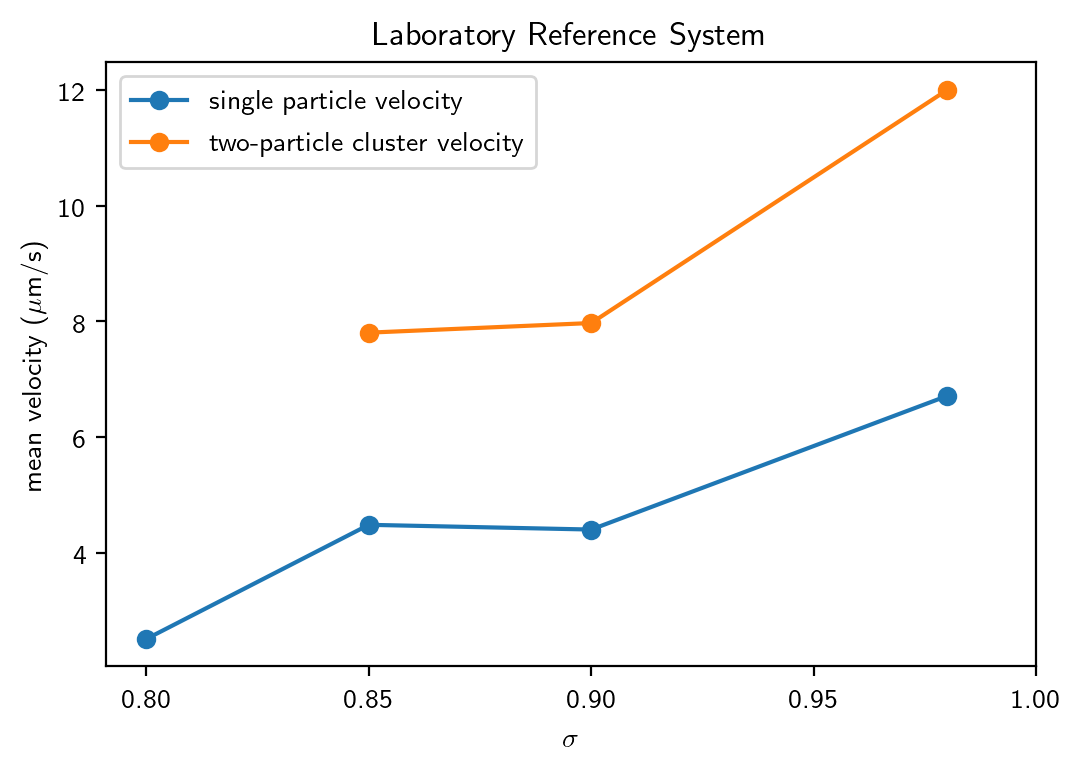

In [33]:
plt.plot(mean_velocities_lab.single_vel, 'o-', label = "single particle velocity");
plt.plot(mean_velocities_lab.cluster_vel, 'o-', label = "two-particle cluster velocity")
plt.ylabel("mean velocity ($\mu$m/s)")
plt.xlabel(r"$\sigma$")
# plt.ylim([-0.5,0])
# plt.xlim([0.79,1])
plt.xticks(np.linspace(0.8,1,5))
plt.title("Laboratory Reference System")
plt.legend();

With the plot above, it is seen that we are in the order of magnitude reported by Lutz 

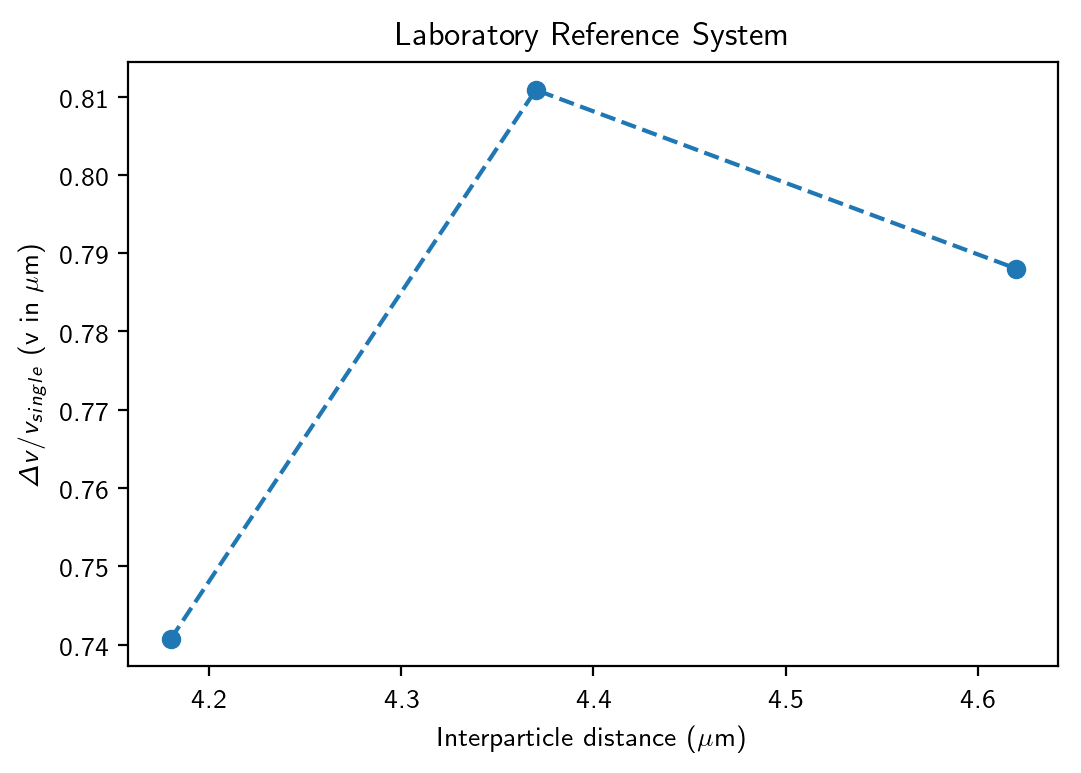

In [34]:
s_vel_lab = mean_velocities_lab.single_vel.values[1:]
delta_v_lab = mean_velocities_lab.cluster_vel.values[1:]-s_vel_lab
plt.plot(index.loc[idx[[0.85,0.9,0.98],3],"wavelength"].values, delta_v_lab/s_vel_lab, 'o--')
plt.ylabel(r"$\Delta v/v_{single}$ (v in $\mu$m)");
plt.xlabel(r"Interparticle distance ($\mu$m)");
plt.title("Laboratory Reference System");

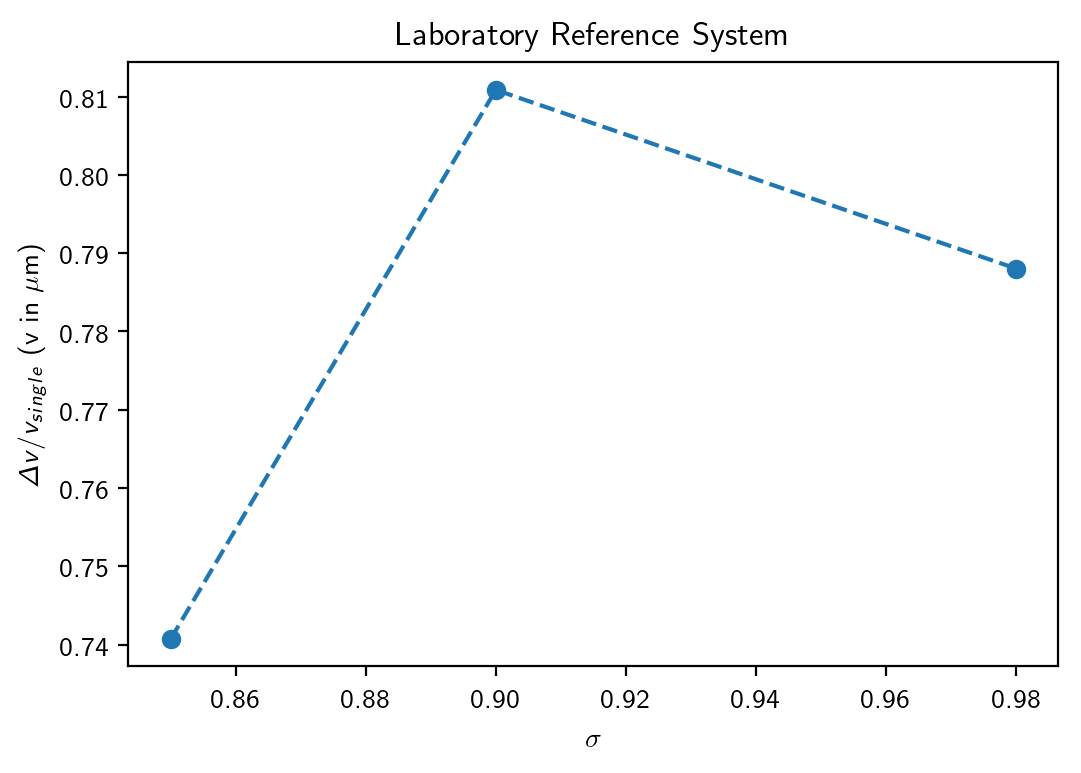

In [35]:
s_vel = mean_velocities_lab.single_vel
delta_v = mean_velocities_lab.cluster_vel-s_vel
plt.plot(delta_v/s_vel, 'o--')
plt.ylabel(r"$\Delta v/v_{single}$ (v in $\mu$m)");
plt.xlabel(r"$\sigma$");
plt.title("Laboratory Reference System");

From the plot $\Delta v$/$v_{single}$(d), where d is the interparticle distance, it is seen the order of magnitude of this ratio is similar to that obtained with hydrodynamic simulations.

# Histograms in Laboratory Reference System

In [36]:
from pylab import *
from scipy.optimize import curve_fit



def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

def bimodal(x,mu1,sigma1,A1,mu2,sigma2,A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

def bimodal_fit(x, y, expected):
    
    x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
    
    return curve_fit(bimodal,x,y,expected) #params,cov=
    
    
# sigma=sqrt(diag(cov))
# plt.plot(x,bimodal(x,*params),color='red',lw=3,label='model')
# legend()
# print(params,'\n',sigma) 

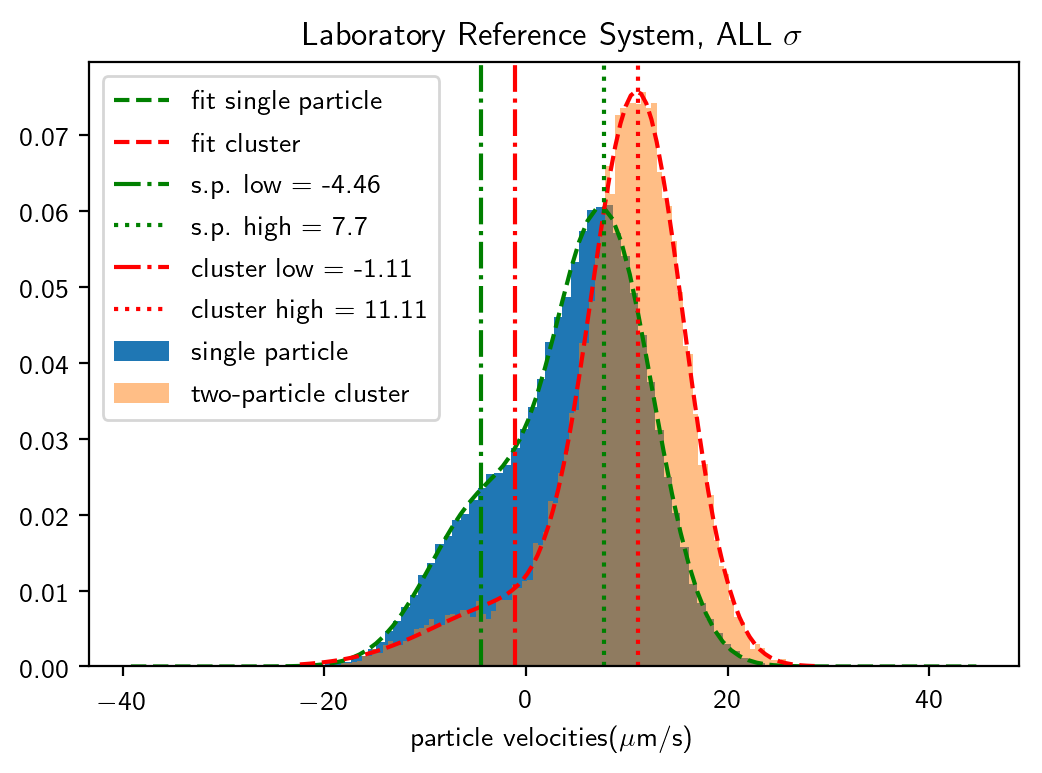

In [37]:
ns, bins_s, patches_s = plt.hist(df.theta_dot[df.cluster==0], 100, density = 1, label="single particle")
# plt.axvline(df.theta_dot[df.cluster==0].mean(), ls = '--', c = "b",
#             label= r"mean of s.p. velocity {0}".format(round(df.theta_dot[df.cluster==0].mean(), 2)))

nc, bins_c, patches_c = plt.hist(df.theta_dot[df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5)
# plt.axvline(df.theta_dot[df.cluster>0].mean(), ls = '--', c = "y",
#             label= r"mean of cluster velocity {0}".format(round(df.theta_dot[df.cluster>0].mean(), 2)))


params_s, cov_s = bimodal_fit(bins_s, ns,[-5,3,0.03,5,2,0.06])
params_c, cov_c = bimodal_fit(bins_c, nc, [-10,2,0.01,10,2,0.07])

plt.plot(bins_s, bimodal(bins_s,*params_s), "g--", label = "fit single particle")
plt.plot(bins_c, bimodal(bins_c,*params_c), "r--", label = "fit cluster")

mean_little_s = params_s[0]
plt.axvline(mean_little_s, ls = '-.', c = "g",
            label= r"s.p. low = {0}".format(round(mean_little_s, 2)))

mean_big_s = params_s[3]
plt.axvline(mean_big_s, ls = ':', c = "g",
            label= r"s.p. high = {0}".format(round(mean_big_s, 2)))

mean_little_c = params_c[0]
plt.axvline(mean_little_c, ls = '-.', c = "r",
            label= r"cluster low = {0}".format(round(mean_little_c, 2)))

mean_big_c = params_c[3]
plt.axvline(mean_big_c, ls = ':', c = "r",
            label= r"cluster high = {0}".format(round(mean_big_c, 2)))


plt.xlabel("particle velocities($\mu$m/s)");
plt.title("Laboratory Reference System, ALL $\sigma$")
plt.legend();

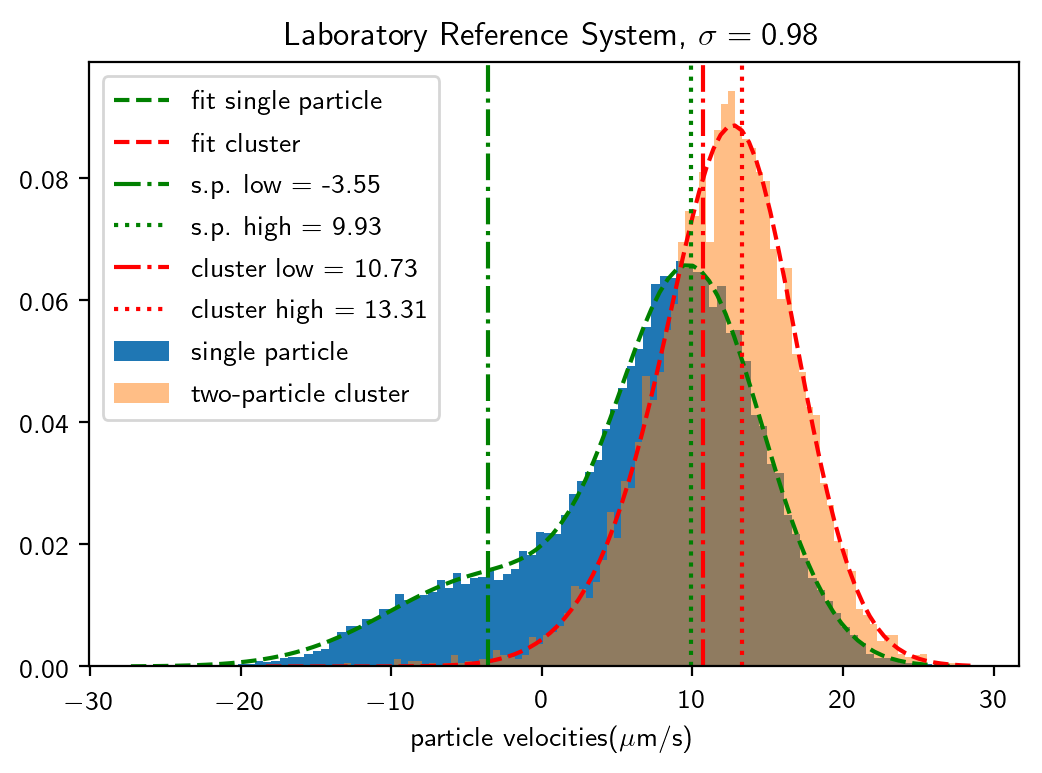

In [84]:
ns, bins_s, patches_s = plt.hist(df.loc[idx[0.98,:,:],"theta_dot"][df.cluster==0], 100, density = 1,
                                 label="single particle");
nc, bins_c, patches_c = plt.hist(df.loc[idx[0.98,:,:],"theta_dot"][df.cluster>0], 100, density = 1,
                                 label="two-particle cluster", alpha=0.5);

params_s, cov_s = bimodal_fit(bins_s, ns,[-5,3,0.03,5,2,0.06])
params_c, cov_c = bimodal_fit(bins_c, nc, [-10,2,0.01,10,2,0.07])

plt.plot(bins_s, bimodal(bins_s,*params_s), "g--", label = "fit single particle")
plt.plot(bins_c, bimodal(bins_c,*params_c), "r--", label = "fit cluster")

mean_little_s_098 = params_s[0]
plt.axvline(mean_little_s_098, ls = '-.', c = "g",
            label= r"s.p. low = {0}".format(round(mean_little_s_098, 2)))

mean_big_s_098 = params_s[3]
plt.axvline(mean_big_s_098, ls = ':', c = "g",
            label= r"s.p. high = {0}".format(round(mean_big_s_098, 2)))

mean_little_c_098 = params_c[0]
plt.axvline(mean_little_c_098, ls = '-.', c = "r",
            label= r"cluster low = {0}".format(round(mean_little_c_098, 2)))

mean_big_c_098 = params_c[3]
plt.axvline(mean_big_c_098, ls = ':', c = "r",
            label= r"cluster high = {0}".format(round(mean_big_c_098, 2)))


plt.xlabel("particle velocities($\mu$m/s)");
plt.title("Laboratory Reference System, $\sigma = 0.98$")
plt.legend();

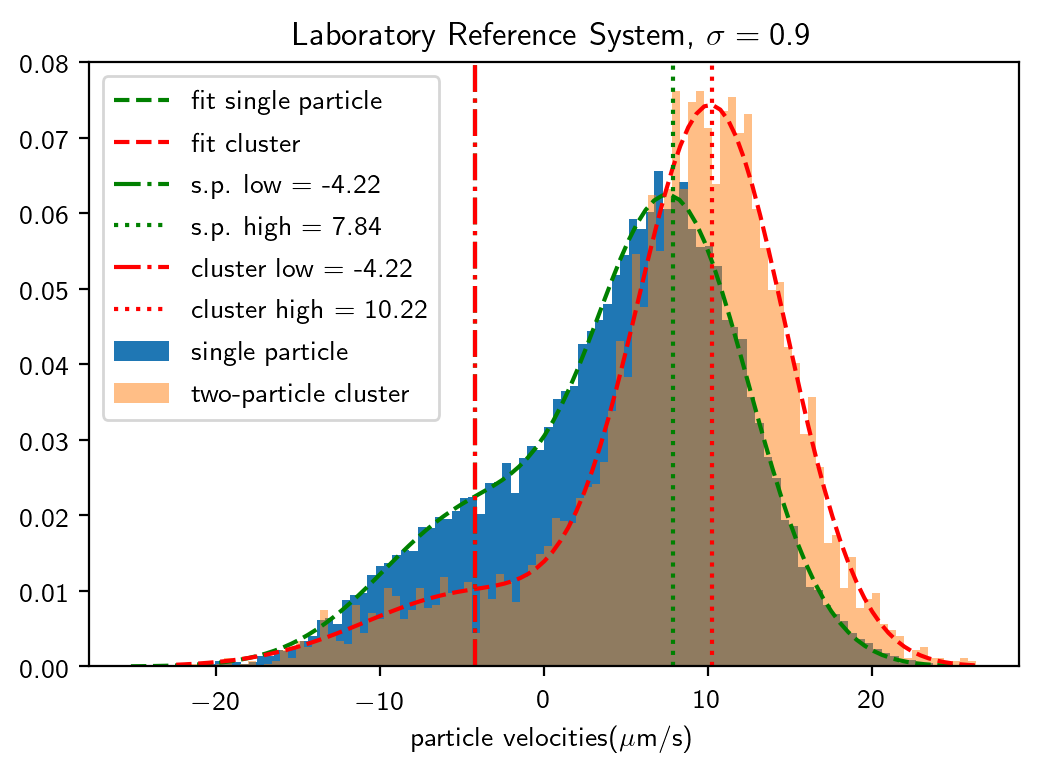

In [85]:
ns, bins_s, patches_s = plt.hist(df.loc[idx[0.9,:,:],"theta_dot"][df.cluster==0], 100, density = 1, label="single particle");
nc, bins_c, patches_c = plt.hist(df.loc[idx[0.9,:,:],"theta_dot"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);

params_s, cov_s = bimodal_fit(bins_s, ns,[-5,3,0.03,5,2,0.06])
params_c, cov_c = bimodal_fit(bins_c, nc, [-10,2,0.01,10,2,0.07])

plt.plot(bins_s, bimodal(bins_s,*params_s), "g--", label = "fit single particle")
plt.plot(bins_c, bimodal(bins_c,*params_c), "r--", label = "fit cluster")

mean_little_s_09 = params_s[0]
plt.axvline(mean_little_s_09, ls = '-.', c = "g",
            label= r"s.p. low = {0}".format(round(mean_little_s_09, 2)))

mean_big_s_09 = params_s[3]
plt.axvline(mean_big_s_09, ls = ':', c = "g",
            label= r"s.p. high = {0}".format(round(mean_big_s_09, 2)))

mean_little_c_09 = params_c[0]
plt.axvline(mean_little_c_09, ls = '-.', c = "r",
            label= r"cluster low = {0}".format(round(mean_little_c_09, 2)))

mean_big_c_09 = params_c[3]
plt.axvline(mean_big_c_09, ls = ':', c = "r",
            label= r"cluster high = {0}".format(round(mean_big_c_09, 2)))

plt.xlabel("particle velocities($\mu$m/s)");
plt.title("Laboratory Reference System, $\sigma = 0.9$")
plt.legend();

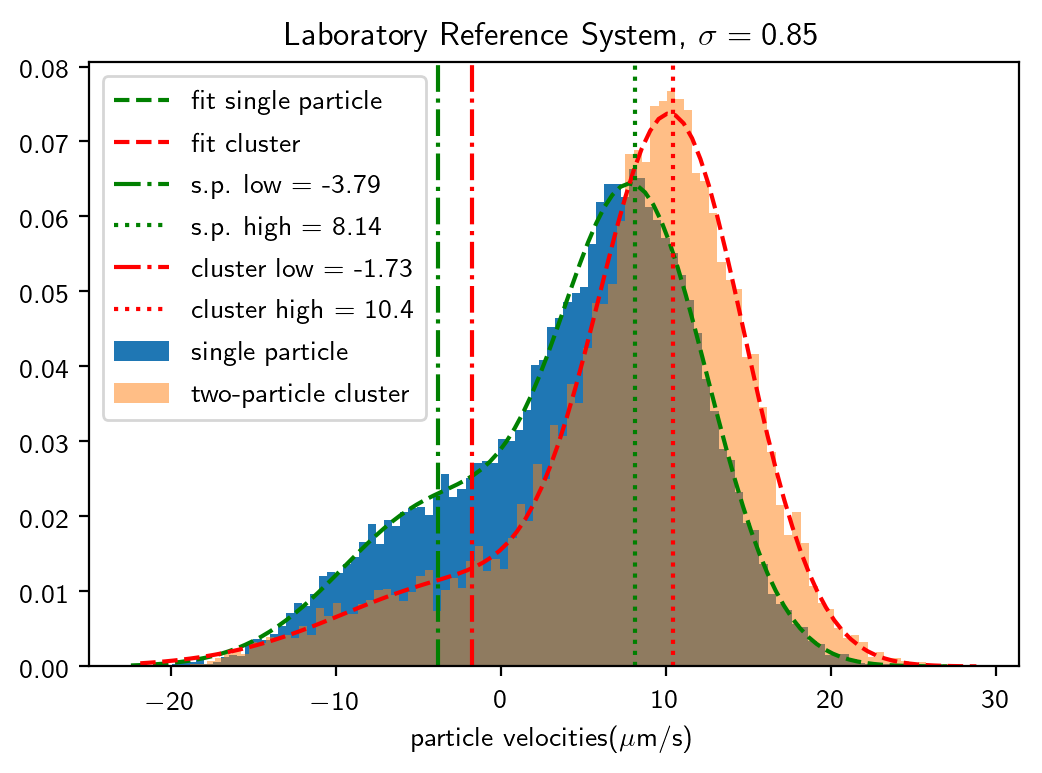

In [86]:
ns, bins_s, patches_s = plt.hist(df.loc[idx[0.85,:,:],"theta_dot"][df.cluster==0], 100, density = 1, label="single particle");
nc, bins_c, patches_c = plt.hist(df.loc[idx[0.85,:,:],"theta_dot"][df.cluster>0], 100, density = 1, label="two-particle cluster", alpha=0.5);

params_s, cov_s = bimodal_fit(bins_s, ns,[-5,3,0.03,5,2,0.06])
params_c, cov_c = bimodal_fit(bins_c, nc, [-10,2,0.01,10,2,0.07])

plt.plot(bins_s, bimodal(bins_s,*params_s), "g--", label = "fit single particle")
plt.plot(bins_c, bimodal(bins_c,*params_c), "r--", label = "fit cluster")

mean_little_s_085 = params_s[0]
plt.axvline(mean_little_s_085, ls = '-.', c = "g",
            label= r"s.p. low = {0}".format(round(mean_little_s_085, 2)))

mean_big_s_085 = params_s[3]
plt.axvline(mean_big_s_085, ls = ':', c = "g",
            label= r"s.p. high = {0}".format(round(mean_big_s_085, 2)))

mean_little_c_085 = params_c[0]
plt.axvline(mean_little_c_085, ls = '-.', c = "r",
            label= r"cluster low = {0}".format(round(mean_little_c_085, 2)))

mean_big_c_085 = params_c[3]
plt.axvline(mean_big_c_085, ls = ':', c = "r",
            label= r"cluster high = {0}".format(round(mean_big_c_085, 2)))

plt.xlabel(r"particle velocities($\mu$m/s)");
plt.title("Laboratory Reference System, $\sigma = 0.85$")
plt.legend();

In [55]:
big_mean_vel_s = np.array([mean_big_s_085, mean_big_s_09, mean_big_s_098])
big_mean_vel_c = np.array([mean_big_c_085, mean_big_c_09, mean_big_c_098])
print(big_mean_vel_s)
big_mean_vel_c

[8.14296055 7.84092324 9.92512554]


array([10.39694904, 10.21794483, 13.30996548])

In [78]:
sigmas = index.index.get_level_values("sigma").unique()[-3:]

3

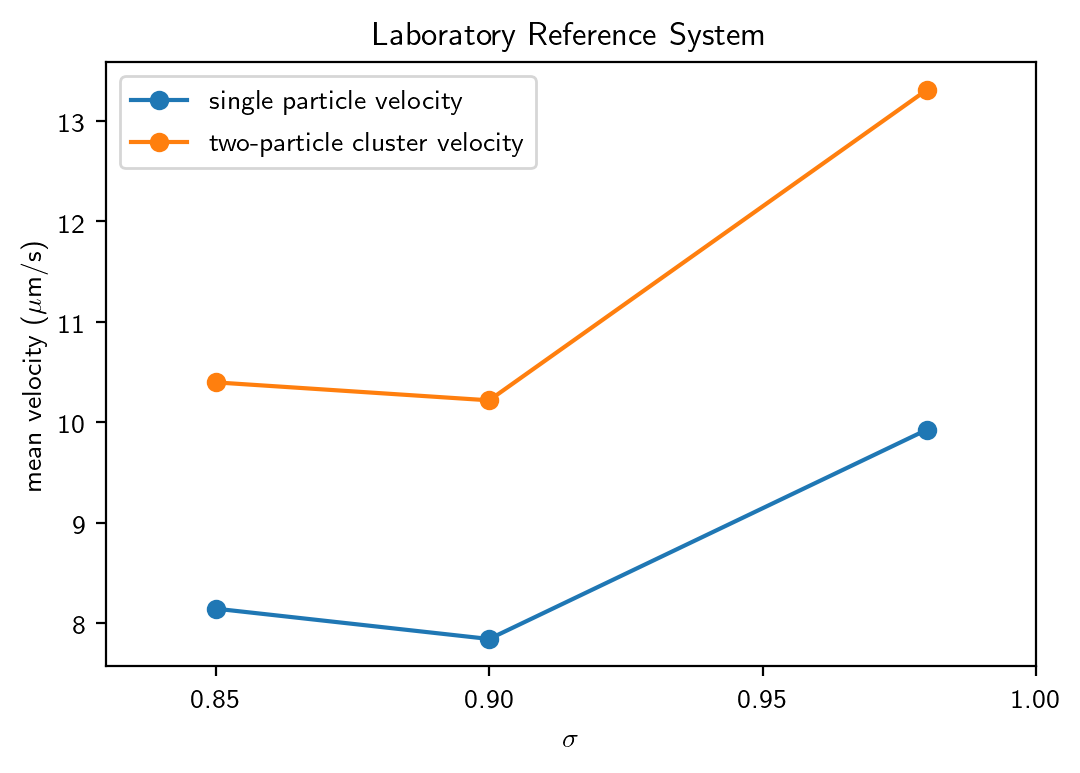

In [88]:
plt.plot(sigmas, big_mean_vel_s, 'o-', label = "single particle velocity");
plt.plot(sigmas, big_mean_vel_c, 'o-', label = "two-particle cluster velocity")
plt.ylabel("mean velocity ($\mu$m/s)")
plt.xlabel(r"$\sigma$")
# plt.ylim([-0.5,0])
plt.xlim([0.83,1])
plt.xticks(np.linspace(0.85,1,4))
plt.title("Laboratory Reference System")
plt.legend();

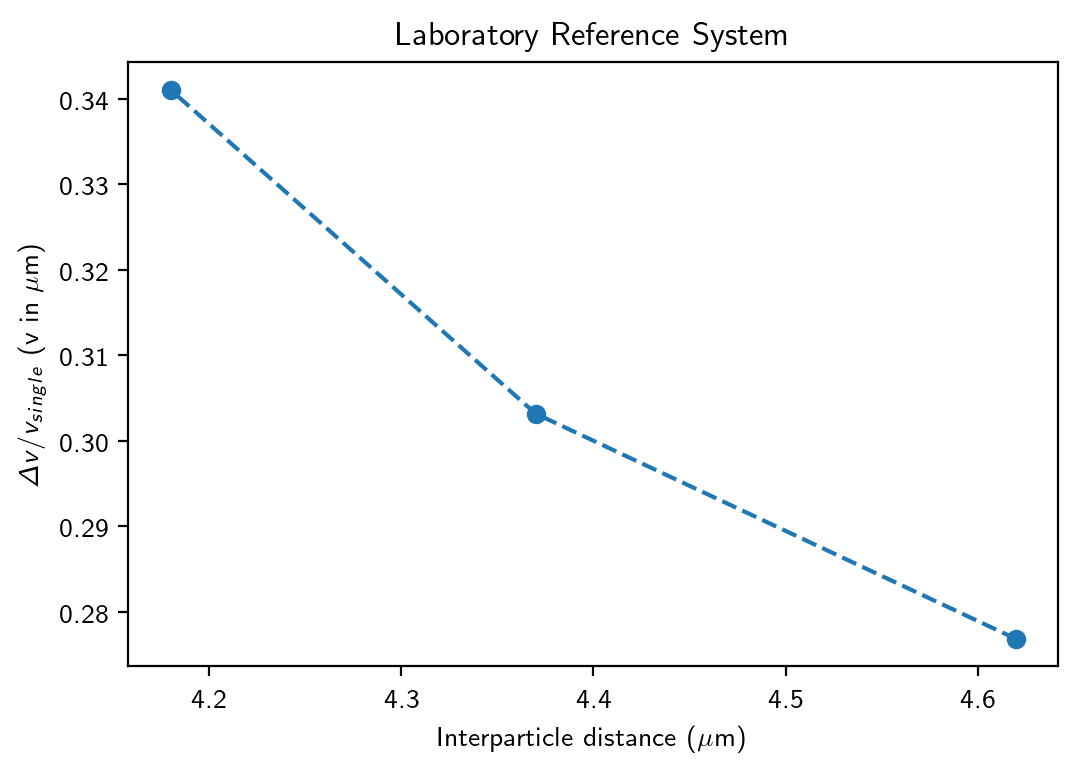

In [60]:
s_vel_lab = big_mean_vel_s
delta_v_lab = big_mean_vel_c-s_vel_lab
plt.plot(index.loc[idx[[0.85,0.9,0.98],3],"wavelength"].values, delta_v_lab/s_vel_lab, 'o--')
plt.ylabel(r"$\Delta v/v_{single}$ (v in $\mu$m)");
plt.xlabel(r"Interparticle distance ($\mu$m)");
plt.title("Laboratory Reference System");

In [41]:
mean_index = index.groupby(["sigma"]).mean()
mean_index.radius*mean_index.omega

sigma
0.62    12.6362
0.75    12.3120
0.80    12.5965
0.85    12.6441
0.90    12.5400
0.98    12.5496
dtype: float64

In [42]:
mean_index

,omega,radius,wavelength
sigma,,,
0.62,0.46,27.47,6.59
0.75,0.54,22.80,5.36
0.80,0.59,21.35,4.91
0.85,0.63,20.07,4.62
0.90,0.66,19.00,4.37
0.98,0.72,17.43,4.18
